In [1]:
import pulp
import numpy as np

# Definiere die Indizes für Mitarbeiter, Tage und Schichten
employees = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L"]
days = range(1, 15)  # Tage 1 bis 14
shifts = ["M", "T", "N"]  # M = Morgen, T = Mittag, N = Nacht
weekend_days = {6, 7, 13, 14}  # Wochenende: Samstag und Sonntag

# Präferenzen der Mitarbeiter
high_prefs = {
    "A": [(2, "M"), (8, "T")],
    "B": [(3, "N"), (9, "M")],
    "C": [(1, "T"), (7, "N")],
    "D": [(5, "M"), (12, "T")],
    "E": [(4, "N"), (10, "M")],
    "F": [(6, "T"), (13, "N")],
    "G": [(2, "M"), (9, "T")],
    "H": [(1, "N"), (7, "M")],
    "I": [(4, "T"), (11, "N")],
    "J": [(6, "M"), (14, "T")],
    "K": [(5, "N"), (12, "M")],
    "L": [(3, "T"), (10, "N")],
}

low_prefs = {
    "A": [(5, "N"), (10, "M"), (13, "T")],
    "B": [(5, "T"), (10, "N"), (14, "M")],
    "C": [(3, "M"), (9, "T"), (12, "N")],
    "D": [(2, "N"), (7, "M"), (9, "T")],
    "E": [(1, "T"), (8, "N"), (13, "M")],
    "F": [(4, "M"), (9, "T"), (14, "N")],
    "G": [(3, "N"), (8, "M"), (11, "T")],
    "H": [(2, "T"), (6, "N"), (10, "M")],
    "I": [(2, "M"), (7, "T"), (13, "N")],
    "J": [(1, "N"), (9, "M"), (11, "T")],
    "K": [(4, "T"), (9, "N"), (13, "M")],
    "L": [(1, "M"), (6, "T"), (11, "N")],
}

# Strafkosten für Präferenzverletzung
X = 10  # Kosten für nicht erfüllte Prio-1-Wünsche
Y = 5   # Kosten für nicht erfüllte Prio-2-Wünsche

# Erstelle das Problem
problem = pulp.LpProblem("Schichtplanung", pulp.LpMinimize)

# Entscheidungsvariablen: x[MA][Tag][Schicht] 
# Binär: 1, wenn der Mitarbeiter an diesem Tag in der Schicht arbeitet, sonst 0
x = pulp.LpVariable.dicts("x", (employees, days, shifts), cat='Binary')

# Nebenbedingungen
# 1. Jeder Mitarbeiter kann nur eine Schicht pro Tag arbeiten
for e in employees:
    for d in days:
        problem += pulp.lpSum(x[e][d][s] for s in shifts) <= 1

# 2. Jede Schicht benötigt genau 3 Mitarbeiter
for d in days:
    for s in shifts:
        problem += pulp.lpSum(x[e][d][s] for e in employees) == 3

# 3. Korrektur der Mindestpause von 2 Schichten zwischen den Diensten
for e in employees:
    for d in range(1, 13):  # bis Tag 12, da wir d, d+1 und d+2 betrachten
        problem += x[e][d]["N"] + x[e][d+1]["M"] + x[e][d+2]["T"] <= 1  # Nacht → 2 Schichten Pause
        problem += x[e][d]["T"] + x[e][d+1]["M"] <= 1  # Mittag → nächste Morgen nicht
        problem += x[e][d]["N"] + x[e][d+1]["M"] <= 1  # Nacht → nächste Morgen nicht
        problem += x[e][d]["N"] + x[e][d+1]["T"] <= 1  # Nacht → nächste Mittag nicht
        
# 4. Maximale Arbeitsdauer von 4 Tagen in Folge
for e in employees:
    for d in range(1, 11):  # bis Tag 10, um 5-Tage-Blöcke zu überprüfen
        problem += pulp.lpSum(x[e][t][s] for t in range(d, d+5) for s in shifts) <= 4

# Zielfunktion: Minimierung der Strafkosten für Präferenzen
penalty_high = pulp.lpSum((1 - x[e][d][s]) * X for e in employees for (d, s) in high_prefs[e])
penalty_low = pulp.lpSum((1 - x[e][d][s]) * Y for e in employees for (d, s) in low_prefs[e])
problem += penalty_high + penalty_low, "TotalPenaltyCost"

# Lösen des Problems
problem.solve(pulp.PULP_CBC_CMD(msg=True))

# Ausgabe der optimalen Lösung
print("Optimale Strafkosten:", pulp.value(problem.objective))
for d in days:
    assigned = {s: [] for s in shifts}
    for e in employees:
        for s in shifts:
            if pulp.value(x[e][d][s]) == 1:
                assigned[s].append(e)
    print(f"Tag {d}: " +
          f"Morgen: {assigned['M']}, " +
          f"Mittag: {assigned['T']}, " +
          f"Nacht: {assigned['N']}")

# Statistikberechnung
shifts_per_employee = {e: sum(pulp.value(x[e][d][s]) for d in days for s in shifts) for e in employees}
night_shifts_per_employee = {e: sum(pulp.value(x[e][d]["N"]) for d in days) for e in employees}
weekend_shifts_per_employee = {e: sum(pulp.value(x[e][d][s]) for d in weekend_days for s in shifts) for e in employees}

# 1. Sortierte Liste der Nachtschichten pro Mitarbeiter
sorted_night_shifts = sorted(night_shifts_per_employee.items(), key=lambda item: item[1], reverse=True)

print("\n🔹 Nachtschichten pro Mitarbeiter (sortiert von viel zu wenig):")
for e, count in sorted_night_shifts:
    print(f"{e}: {count} Nachtschichten")

print("\n🔹 Mitarbeiter mit den meisten Schichten:", max(shifts_per_employee, key=shifts_per_employee.get), "mit", max(shifts_per_employee.values()), "Schichten")
print("🔹 Mitarbeiter mit den wenigsten Schichten:", min(shifts_per_employee, key=shifts_per_employee.get), "mit", min(shifts_per_employee.values()), "Schichten")
print("🔹 Durchschnittliche Schichtanzahl pro Mitarbeiter:", np.mean(list(shifts_per_employee.values())))

print("\n🔹 Mitarbeiter mit den meisten Nachtschichten:", max(night_shifts_per_employee, key=night_shifts_per_employee.get), "mit", max(night_shifts_per_employee.values()), "Nachtschichten")
print("🔹 Mitarbeiter mit den wenigsten Nachtschichten:", min(night_shifts_per_employee, key=night_shifts_per_employee.get), "mit", min(night_shifts_per_employee.values()), "Nachtschichten")
print("🔹 Durchschnittliche Anzahl an Nachtschichten:", np.mean(list(night_shifts_per_employee.values())))

print("\n🔹 Mitarbeiter mit den meisten Wochenendschichten:", max(weekend_shifts_per_employee, key=weekend_shifts_per_employee.get), "mit", max(weekend_shifts_per_employee.values()), "Wochenendschichten")
print("🔹 Mitarbeiter mit den wenigsten Wochenendschichten:", min(weekend_shifts_per_employee, key=weekend_shifts_per_employee.get), "mit", min(weekend_shifts_per_employee.values()), "Wochenendschichten")
print("🔹 Durchschnittliche Anzahl an Wochenendschichten:", np.mean(list(weekend_shifts_per_employee.values())))

# 2. Berechnung der längsten Arbeitsserie pro Mitarbeiter
def longest_consecutive_work_days(employee):
    max_streak = 0
    current_streak = 0
    for d in days:
        worked = any(pulp.value(x[employee][d][s]) for s in shifts)
        if worked:
            current_streak += 1
            max_streak = max(max_streak, current_streak)
        else:
            current_streak = 0
    return max_streak

work_streaks = {e: longest_consecutive_work_days(e) for e in employees}
max_streak_employee = max(work_streaks, key=work_streaks.get)
max_streak = work_streaks[max_streak_employee]

print("\n🔹 Mitarbeiter mit den meisten aufeinanderfolgenden Arbeitstagen:", max_streak_employee, "mit", max_streak, "Tagen am Stück")

# 3. Präferenzverstöße analysieren
violated_high_prefs = []
violated_low_prefs = []

for e in employees:
    if e in high_prefs:
        for d, s in high_prefs[e]:
            if pulp.value(x[e][d][s]) != 1:  # Wenn Präferenz nicht erfüllt wurde
                violated_high_prefs.append((e, d, s))

    if e in low_prefs:
        for d, s in low_prefs[e]:
            if pulp.value(x[e][d][s]) == 1:  # Wenn der Mitarbeiter trotz niedriger Präferenz zugewiesen wurde
                violated_low_prefs.append((e, d, s))

# Präferenzverstöße ausgeben
print("\n🚨 **Nicht eingehaltene Prio1-Präferenzen:**")
if violated_high_prefs:
    for v in violated_high_prefs:
        print(f"Mitarbeiter {v[0]} wollte an Tag {v[1]} in Schicht {v[2]} arbeiten, wurde aber nicht zugeteilt.")
else:
    print("✅ Alle High-Präferenzen wurden erfüllt!")

print("\n⚠️ **Eingehaltene Low-Präferenzen (unerwünscht):**")
if violated_low_prefs:
    for v in violated_low_prefs:
        print(f"Mitarbeiter {v[0]} wollte NICHT an Tag {v[1]} in Schicht {v[2]} arbeiten, wurde aber trotzdem zugeteilt.")
else:
    print("✅ Keine Low-Präferenzen wurden verletzt!")


Optimale Strafkosten: 30.0
Tag 1: Morgen: ['G', 'I', 'L'], Mittag: ['C', 'E', 'F'], Nacht: ['D', 'H', 'J']
Tag 2: Morgen: ['A', 'G', 'I'], Mittag: ['B', 'E', 'K'], Nacht: ['D', 'H', 'J']
Tag 3: Morgen: ['A', 'C', 'F'], Mittag: ['E', 'K', 'L'], Nacht: ['B', 'G', 'J']
Tag 4: Morgen: ['A', 'D', 'F'], Mittag: ['I', 'K', 'L'], Nacht: ['E', 'H', 'J']
Tag 5: Morgen: ['A', 'D', 'G'], Mittag: ['C', 'I', 'L'], Nacht: ['B', 'H', 'K']
Tag 6: Morgen: ['D', 'G', 'J'], Mittag: ['F', 'I', 'L'], Nacht: ['B', 'C', 'E']
Tag 7: Morgen: ['D', 'H', 'J'], Mittag: ['A', 'F', 'I'], Nacht: ['C', 'E', 'K']
Tag 8: Morgen: ['B', 'H', 'J'], Mittag: ['A', 'F', 'G'], Nacht: ['E', 'K', 'L']
Tag 9: Morgen: ['B', 'H', 'J'], Mittag: ['D', 'F', 'G'], Nacht: ['I', 'K', 'L']
Tag 10: Morgen: ['A', 'E', 'H'], Mittag: ['C', 'D', 'G'], Nacht: ['B', 'K', 'L']
Tag 11: Morgen: ['A', 'E', 'F'], Mittag: ['D', 'G', 'J'], Nacht: ['C', 'I', 'L']
Tag 12: Morgen: ['B', 'E', 'K'], Mittag: ['D', 'H', 'J'], Nacht: ['C', 'F', 'I']
Tag 13: Mo

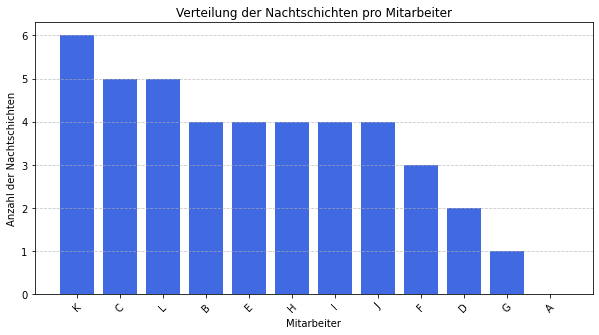

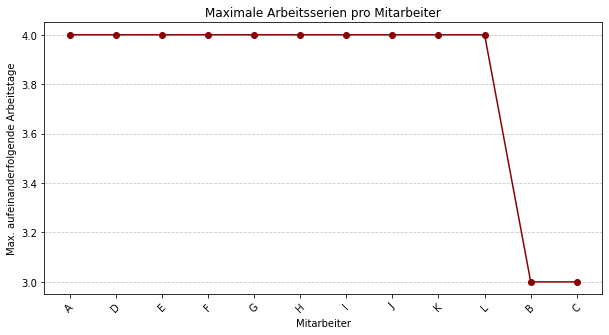

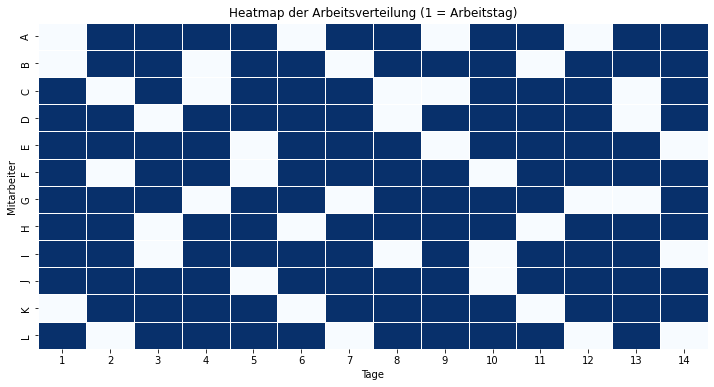

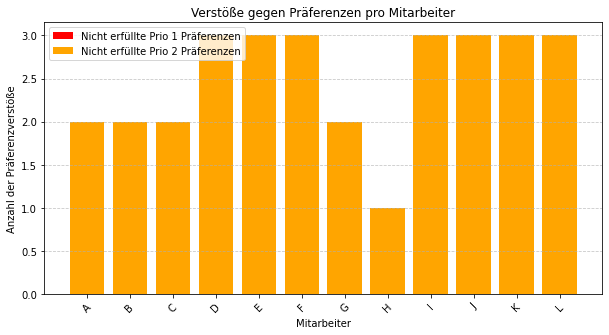

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1️⃣ Balkendiagramm: Nachtschichtverteilung
sorted_night_shifts = sorted(night_shifts_per_employee.items(), key=lambda item: item[1], reverse=True)
employees_sorted, night_shifts_sorted = zip(*sorted_night_shifts)

plt.figure(figsize=(10, 5))
plt.bar(employees_sorted, night_shifts_sorted, color="royalblue")
plt.xlabel("Mitarbeiter")
plt.ylabel("Anzahl der Nachtschichten")
plt.title("Verteilung der Nachtschichten pro Mitarbeiter")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# 2️⃣ Liniendiagramm: Längste aufeinanderfolgende Arbeitstage
employees_sorted, max_streaks = zip(*sorted(work_streaks.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(10, 5))
plt.plot(employees_sorted, max_streaks, marker="o", linestyle="-", color="darkred")
plt.xlabel("Mitarbeiter")
plt.ylabel("Max. aufeinanderfolgende Arbeitstage")
plt.title("Maximale Arbeitsserien pro Mitarbeiter")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# 3️⃣ Heatmap für Schichtverteilung
heatmap_data = np.zeros((len(employees), len(days)))

for i, e in enumerate(employees):
    for j, d in enumerate(days):
        if any(pulp.value(x[e][d][s]) == 1 for s in shifts):
            heatmap_data[i, j] = 1

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="Blues", xticklabels=days, yticklabels=employees, cbar=False, linewidths=0.5)
plt.xlabel("Tage")
plt.ylabel("Mitarbeiter")
plt.title("Heatmap der Arbeitsverteilung (1 = Arbeitstag)")
plt.show()

# 4️⃣ Gestapelte Balkendiagramme: Präferenzverstöße
high_pref_violations = {e: sum(1 for d, s in high_prefs.get(e, []) if pulp.value(x[e][d][s]) != 1) for e in employees}
low_pref_violations = {e: sum(1 for d, s in low_prefs.get(e, []) if pulp.value(x[e][d][s]) == 1) for e in employees}

high_violations_sorted = sorted(high_pref_violations.items(), key=lambda item: item[1], reverse=True)
low_violations_sorted = sorted(low_pref_violations.items(), key=lambda item: item[1], reverse=True)

high_employees, high_violations = zip(*high_violations_sorted)
low_employees, low_violations = zip(*low_violations_sorted)

plt.figure(figsize=(10, 5))
plt.bar(high_employees, high_violations, color="red", label="Nicht erfüllte Prio 1 Präferenzen")
plt.bar(low_employees, low_violations, bottom=high_violations, color="orange", label="Nicht erfüllte Prio 2 Präferenzen")
plt.xlabel("Mitarbeiter")
plt.ylabel("Anzahl der Präferenzverstöße")
plt.title("Verstöße gegen Präferenzen pro Mitarbeiter")
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
